In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


In [2]:
import torch
import torch.nn as nn

In [3]:
df = pd.read_csv('incoming_daily_till2023may_interpolated.csv')

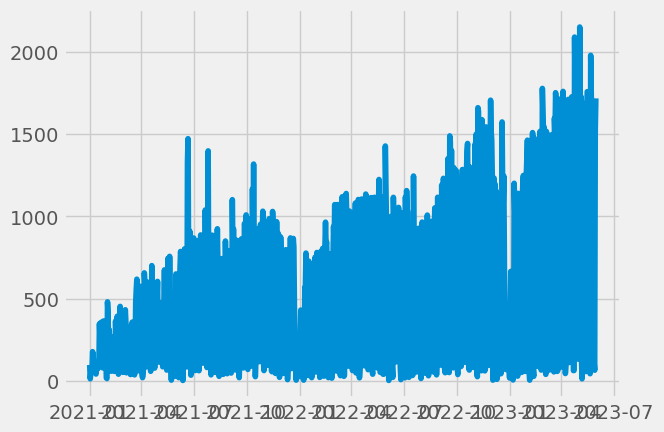

In [4]:
df['date'] = pd.to_datetime(df['date'])

plt.plot(df['date'], df['volume'])

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'volume(t-{i})'] = df['volume'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 3
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,volume,volume(t-1),volume(t-2),volume(t-3)
date,,,,
2021-01-04,61.00,50.00,15.00,99.00
2021-01-05,63.00,61.00,50.00,15.00
2021-01-06,180.00,63.00,61.00,50.00
2021-01-07,167.00,180.00,63.00,61.00
2021-01-08,68.00,167.00,180.00,63.00
...,...,...,...,...
2023-05-27,166.50,1329.00,1515.50,1532.00
2023-05-28,116.75,166.50,1329.00,1515.50
2023-05-29,67.00,116.75,166.50,1329.00


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[  61.  ,   50.  ,   15.  ,   99.  ],
       [  63.  ,   61.  ,   50.  ,   15.  ],
       [ 180.  ,   63.  ,   61.  ,   50.  ],
       ...,
       [  67.  ,  116.75,  166.5 , 1329.  ],
       [1520.5 ,   67.  ,  116.75,  166.5 ],
       [1716.5 , 1520.5 ,   67.  ,  116.75]])

In [7]:
shifted_df_as_np.shape

(878, 4)

scaling the numpy array of x and y matrix

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.94777337, -0.95803218, -0.99067382, -0.91233388],
       [-0.94590814, -0.94777337, -0.95803218, -0.99067382],
       [-0.83679179, -0.94590814, -0.94777337, -0.95803218],
       ...,
       [-0.94217766, -0.8957799 , -0.84938214,  0.23478666],
       [ 0.41338307, -0.94217766, -0.8957799 , -0.84938214],
       [ 0.59617626,  0.41338307, -0.94217766, -0.8957799 ]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((878, 3), (878,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.91233388, -0.99067382, -0.95803218],
       [-0.99067382, -0.95803218, -0.94777337],
       [-0.95803218, -0.94777337, -0.94590814],
       ...,
       [ 0.23478666, -0.84938214, -0.8957799 ],
       [-0.84938214, -0.8957799 , -0.94217766],
       [-0.8957799 , -0.94217766,  0.41338307]])

In [11]:
split_index = int(len(X) * 0.80)

split_index

702

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((702, 3), (176, 3), (702,), (176,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((702, 3, 1), (176, 3, 1), (702, 1), (176, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([702, 3, 1]),
 torch.Size([176, 3, 1]),
 torch.Size([702, 1]),
 torch.Size([176, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
import torch
# Check if a GPU is available, and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 3, 1]) torch.Size([16, 1])


In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [21]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [22]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [23]:
learning_rate = 0.001
num_epochs = 60
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.388
***************************************************

Epoch: 2

Val Loss: 0.429
***************************************************

Epoch: 3

Val Loss: 0.459
***************************************************

Epoch: 4

Val Loss: 0.464
***************************************************

Epoch: 5

Val Loss: 0.455
***************************************************

Epoch: 6

Val Loss: 0.449
***************************************************

Epoch: 7

Val Loss: 0.453
***************************************************

Epoch: 8

Val Loss: 0.449
***************************************************

Epoch: 9

Val Loss: 0.445
***************************************************

Epoch: 10

Val Loss: 0.445
***************************************************

Epoch: 11

Val Loss: 0.443
***************************************************

Epoch: 12

Val Loss: 0.444
***************************************************

Epoch: 13

Val Loss: 0.435
**********************

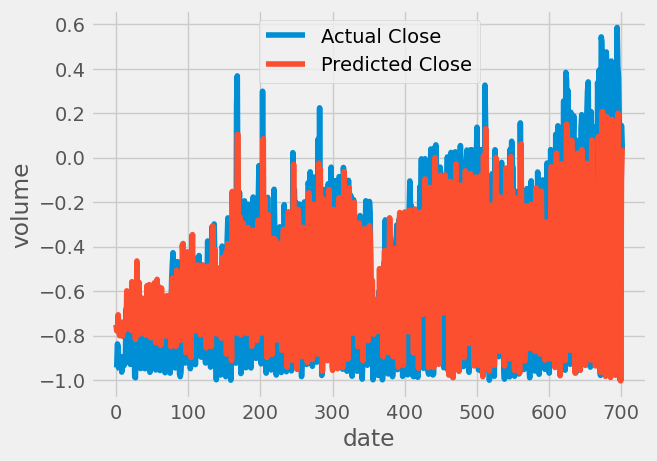

In [24]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('date')
plt.ylabel('volume')
plt.legend()
plt.show()


In [25]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 271.92520232,  243.19467917,  244.38815469,  320.38910238,
        261.14493693,  219.59787746,  284.65194358,  263.06827699,
        261.25754826,  216.73344675,  285.31125028,  246.97680908,
        244.4211328 ,  256.26443119,  254.52694456,  435.74508733,
        275.98381157,  382.10592362,  345.14569847,  266.28530513,
        279.10637914,  244.46887438,  479.70415097,  263.23476535,
        339.09600343,  307.74908847,  258.17275214,  201.26038246,
        276.54507868,  579.76806781,  372.95775549,  227.66467011,
        476.28203218,  227.10851589,  283.67627703,  239.27188097,
        400.88370205,  238.72103137,  286.73231316,  287.29083209,
        261.41489734,  222.42849921,  265.86924399,  460.70287549,
        261.98421724,  291.35033609,  465.54982792,  261.13055694,
        210.12951481,  340.07473771,  402.92163467,  422.53524221,
        231.10730436,  473.93029615,  301.55425136,  185.12794755,
        332.08930387,  491.23192036,  265.8710335 ,  456.86590

In [26]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  60.9999751 ,   63.00000845,  179.99997811,  167.00001699,
         68.00002791,   89.49997099,  110.99997798,  118.99998355,
         44.00001119,   90.00001128,   90.00001128,   75.00001681,
         82.49998209,   90.00001128,  348.999984  ,  263.00001995,
        328.0000173 ,  358.00000624,  252.00002827,  166.49997669,
         80.99998903,  366.00001182,  244.99997546,  241.99998935,
        248.99997824,  179.99997811,   19.99999447,   16.49996807,
        482.00002871,  419.0000008 ,  185.49997395,  313.00002283,
        175.99997532,  118.50000717,   60.9999751 ,  268.99999218,
        170.0000031 ,  143.00000027,  161.99999753,  144.49999332,
         60.00002234,   63.00000845,  365.49997152,  239.00000323,
        166.49997669,  394.99998409,  264.99998939,   42.99999452,
         76.99998625,  307.50002699,  454.49998559,  252.50000465,
        364.50001876,  318.99999505,   70.49997373,   53.9999862 ,
        392.49997436,  248.99997824,  383.9999924 ,  433.99999

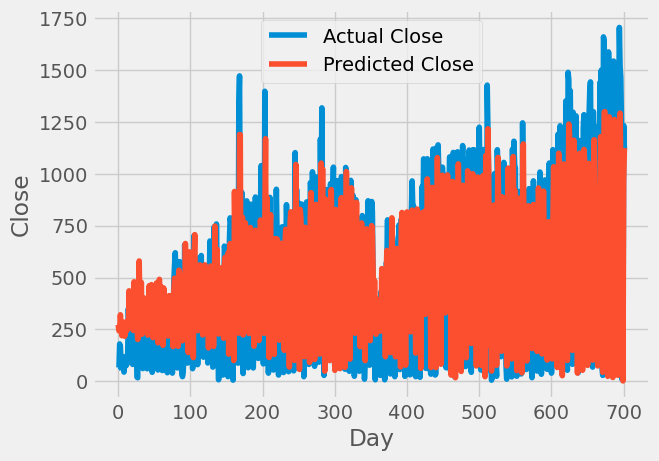

In [27]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [28]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 924.15981075,  811.63925686,  696.62851958,  780.61330335,
          6.41281834,  930.48660826, 1026.59730522,  938.32327309,
        694.29614861,  493.44605583,  845.57663171,   33.97696428,
        903.74656375, 1273.6722852 ,  998.91479596,  695.87903434,
        860.00142646,  382.67006673,  231.00760308,  725.46973673,
        247.44546904,  319.98397005,  307.94817148,  285.98857991,
        270.07913077,  240.99690494,  226.7861484 ,  581.18670206,
        569.43850335,  410.91160621,  383.26290591,  337.42396174,
        174.53813718,  422.05213836, 1114.41450094,  864.28043307,
        755.2985718 ,  639.75264312,  805.65590152,  273.71618253,
        339.72642232, 1172.64195295,  787.80860451,  703.12834036,
        738.01755891,  584.30997264,   70.65125126,  827.82619194,
       1058.72890444,  990.26231418,  826.24124508,  436.48696715,
        896.40163077,   38.40267877,  915.69132098, 1127.69827519,
       1108.62688926,  968.53500743,  750.85937206,  627.14145

In [29]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1195.49999849, 1099.49999952, 1152.00000015,   11.9999889 ,
         32.00000283, 1044.0000008 , 1127.49999906, 1076.49999998,
        817.00000644, 1053.49999943,   45.99998063,   67.00001124,
       1573.50001416, 1167.00000261, 1081.99999981, 1245.49999338,
        755.00001118,   76.99998625,   74.00000013,   71.00001402,
        182.00001146,  240.00001991,  229.5000046 ,  183.9999809 ,
        102.00001964,   19.99999447,  459.00002867,  666.50000545,
        599.50000671,  482.5000051 ,  344.99998121,    7.99998611,
         64.00002512, 1201.50000267, 1034.99999853, 1081.49999996,
        997.49999637, 1139.99999977,  585.49999696,   30.99998616,
       1139.99999977,  938.5000032 ,  957.00000011, 1061.50000001,
        934.99999278,   76.50000986,   53.9999862 , 1100.50000022,
       1195.49999849, 1249.00000381,  821.99999395, 1083.49999986,
         60.00002234,   98.49999323, 1241.50000657, 1358.50000819,
       1462.99999311, 1210.50000095, 1021.50000111,   57.99998

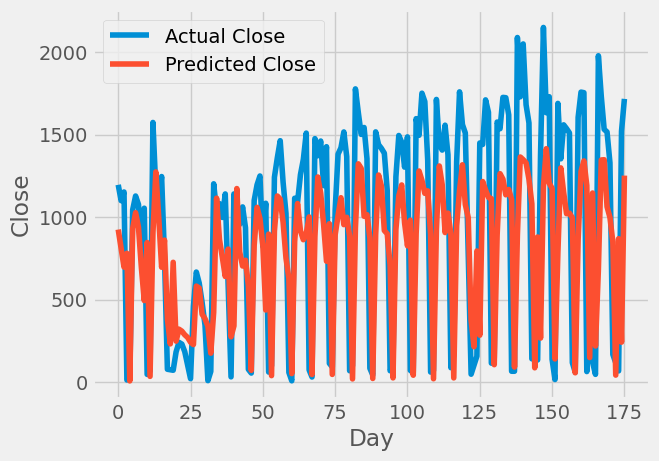

In [30]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [31]:
test_predictions

array([ 924.15981075,  811.63925686,  696.62851958,  780.61330335,
          6.41281834,  930.48660826, 1026.59730522,  938.32327309,
        694.29614861,  493.44605583,  845.57663171,   33.97696428,
        903.74656375, 1273.6722852 ,  998.91479596,  695.87903434,
        860.00142646,  382.67006673,  231.00760308,  725.46973673,
        247.44546904,  319.98397005,  307.94817148,  285.98857991,
        270.07913077,  240.99690494,  226.7861484 ,  581.18670206,
        569.43850335,  410.91160621,  383.26290591,  337.42396174,
        174.53813718,  422.05213836, 1114.41450094,  864.28043307,
        755.2985718 ,  639.75264312,  805.65590152,  273.71618253,
        339.72642232, 1172.64195295,  787.80860451,  703.12834036,
        738.01755891,  584.30997264,   70.65125126,  827.82619194,
       1058.72890444,  990.26231418,  826.24124508,  436.48696715,
        896.40163077,   38.40267877,  915.69132098, 1127.69827519,
       1108.62688926,  968.53500743,  750.85937206,  627.14145

In [32]:
new_y_test

array([1195.49999849, 1099.49999952, 1152.00000015,   11.9999889 ,
         32.00000283, 1044.0000008 , 1127.49999906, 1076.49999998,
        817.00000644, 1053.49999943,   45.99998063,   67.00001124,
       1573.50001416, 1167.00000261, 1081.99999981, 1245.49999338,
        755.00001118,   76.99998625,   74.00000013,   71.00001402,
        182.00001146,  240.00001991,  229.5000046 ,  183.9999809 ,
        102.00001964,   19.99999447,  459.00002867,  666.50000545,
        599.50000671,  482.5000051 ,  344.99998121,    7.99998611,
         64.00002512, 1201.50000267, 1034.99999853, 1081.49999996,
        997.49999637, 1139.99999977,  585.49999696,   30.99998616,
       1139.99999977,  938.5000032 ,  957.00000011, 1061.50000001,
        934.99999278,   76.50000986,   53.9999862 , 1100.50000022,
       1195.49999849, 1249.00000381,  821.99999395, 1083.49999986,
         60.00002234,   98.49999323, 1241.50000657, 1358.50000819,
       1462.99999311, 1210.50000095, 1021.50000111,   57.99998

In [33]:
# Calculate squared differences
squared_differences = (new_y_test - test_predictions) ** 2

# Calculate the mean of squared differences
mse = squared_differences.mean()

# Calculate the RMSE by taking the square root of the mean squared error
rmse = np.sqrt(mse)

print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 512.7762511875576


In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(new_y_test, test_predictions))

print(f'RMSE: {rmse:.4f}')


RMSE: 512.7763


In [35]:
mse = mean_squared_error(new_y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(new_y_test, test_predictions)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
# Calculating Theil's U2 statistic
numerator = np.sum((test_predictions - new_y_test) ** 2)
denominator = np.sum(new_y_test ** 2)

theils_u2 = np.sqrt(numerator / denominator)
print("Theil's u2:", theils_u2)


MSE: 262939.4837819651
RMSE: 512.7762511875576
MAE: 408.7905708987058
Theil's u2: 0.4500605650331856
